<a href="https://colab.research.google.com/github/DasKanadia/Assignment-III/blob/main/asg3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment III - NLP Tokenization
## Loading BigQuery data & Project Access

In [1]:
from google.cloud import bigquery
from google.colab import auth

auth.authenticate_user()
print('Authenticated')
project_id = "dowegraduate"
print('Assigned')

Authenticated
Assigned


In [2]:
%%bigquery df --project dowegraduate
SELECT title, tags
FROM `bigquery-public-data.stackoverflow.posts_questions` as Posts
WHERE ARRAY_LENGTH(SPLIT(Posts.tags, '|')) = 1 AND tags in (
  SELECT tags
  FROM `bigquery-public-data.stackoverflow.posts_questions` as Posts
  WHERE ARRAY_LENGTH(SPLIT(Posts.tags, '|')) = 1
  GROUP BY tags
  ORDER BY COUNT(*) DESC
  LIMIT 10
)
ORDER BY RAND()
LIMIT 150000

Query is running:   0%|          |

Downloading:   0%|          |

,title,tags
0,TypeError: unsupported operand type(s) for +: ...,python
1,How to stop my Android app with a warning when...,android
2,Javascript random integer button,javascript
3,window.location.href.replace does not replace ...,javascript
4,how to close the activity and again show the s...,android


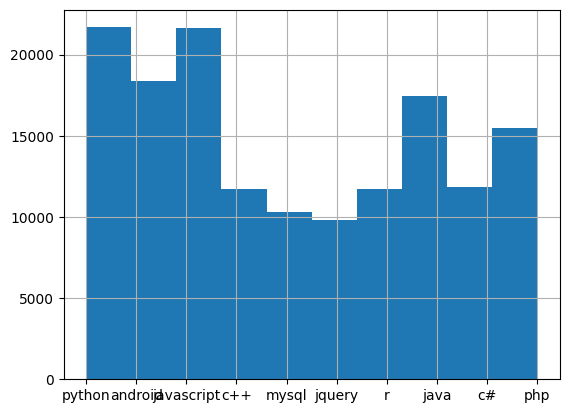

In [3]:
# Look at the distribution of tags
df['tags'].hist()

# Look at the first five rows of the dataframe
df.head()

You might want to do some class balancing or some other preprocessing, but you'll definitely need to do the following:
1. Split the data into training/validation/testing sets
2. Encode the labels as integers or one-hot vectors (there's lots of ways - I chose to use Pandas' `get_dummies` function)
3. Define a `TextVectorization` layer to normalize, split, and map strings to integers - don't forget to take care of the padding values, either by masking or using `RaggedTensor`s
4. Define some kind of model, hopefully better than the one I use as an example

In [4]:
import pandas as pd

tv_thresh = int(.7 * len(df))
vt_thresh = int(.85 * len(df))

# train/val/test split (e.g. 70/15/15)
train_X = df["title"][:tv_thresh].values
val_X = df["title"][tv_thresh:vt_thresh].values
test_X = df["title"][vt_thresh:].values

# encode the output labels
labels = pd.get_dummies(df["tags"])
label_names = labels.columns
train_y = labels[:tv_thresh].values
val_y = labels[tv_thresh:vt_thresh].values
test_y = labels[vt_thresh:].values

The following cell defines the vectorization layer. Lots of important decisions to be made here.

In [5]:
import tensorflow as tf

# define the tokenization/sequencing parameters
vocab_size = 2000
vec_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize="lower",
    output_mode="int",
    output_sequence_length=100  # Adjust based on your data
)
vec_layer.adapt(train_X)

#Model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, preprocessing, regularizers

tokenizer = preprocessing.text.Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_X)  # Fit only on training data

# Define input with proper shape (batch_size, sequence_length)

# inputs = tf.keras.Input(shape=(1,), dtype=tf.int32)
# layering = vec_layer()(inputs)
# layering = layers.Embedding(vocab_size, 64, mask_zero=True)(layering)

# inputs = tf.keras.Input(shape=(1,), dtype=tf.int32)
# layering = layers.Embedding(vocab_size, 64, mask_zero=True)(input)

#

inputs = tf.keras.Input(shape=(100,), dtype=tf.int32)  # Accepts raw text as input
layering = vec_layer(inputs)  # Tokenization inside the model

# inputs = tf.keras.Input(shape=(None,), dtype=tf.int32)
layering = layers.Embedding(vocab_size, 64, mask_zero=True)(inputs)

# Application of Normalization around GRU & Attention
layering = layers.LayerNormalization()(layering)
layering = layering = layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=True))(layering)
layering = layers.MultiHeadAttention(
    num_heads=16, key_dim=64, dropout=0.5)(layering, layering)
layering = layers.BatchNormalization()(layering)

layering = layers.GlobalAveragePooling1D()(layering)
# layering = layers.Dense(32, activation="relu")(layering)
layering = layers.Dropout(0.4)(layering)
outputs = layers.Dense(len(label_names), activation="softmax",
                       kernel_regularizer=regularizers.l2(0.06))(layering)

# Define Model
model = tf.keras.Model(inputs, outputs)
model.summary()

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
#               loss="categorical_crossentropy", metrics=["accuracy"])
# # history = model.fit(x=train_X, y=train_y, validation_data=(val_X, val_y), epochs=50)
# history = model.fit(x=vec_layer(train_X), y=train_y, validation_data=(vec_layer(val_X), val_y), epochs=30)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 64)        │        128,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 100, 64)        │            128 │ embedding[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 100)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 100, 256)       │        148,992 │ layer_normalization[0… │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 100, 256)       │      1,051,904 │ bidirectional[0][0],   │
│ (MultiHeadAttention)      │                        │                │ bidirectional[0][0],   │
│                           │                        │                │ not_equal[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 100, 256)       │          1,024 │ multi_head_attention[… │
│ (BatchNormalization)      │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ batch_normalization[0… │
│ (GlobalAveragePooling1D)  │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10)             │          2,570 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,332,618 (5.08 MB)

 Trainable params: 1,332,106 (5.08 MB)

 Non-trainable params: 512 (2.00 KB)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy", metrics=["accuracy"])
# history = model.fit(x=train_X, y=train_y, validation_data=(val_X, val_y), epochs=50)
history = model.fit(x=vec_layer(train_X), y=train_y, validation_data=(vec_layer(val_X), val_y), epochs=50)

Epoch 1/50
  45/3282 ━━━━━━━━━━━━━━━━━━━━ 1:07:16 1s/step - accuracy: 0.3004 - loss: 3.6344

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.show()

In [ ]:
# inputs = tf.keras.Input(shape=(None,), dtype=tf.int32)

# model = tf.keras.Sequential([
#     vec_layer,
#     tf.keras.layers.Embedding(vocab_size, 128, mask_zero=True),
#     tf.keras.layers.GRU(128),
#     # tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64, dropout=0.1),
#     # tf.keras.layers.GlobalAveragePooling1D(), # Aggregate the output of Attention
#     # tf.keras.layers.Dense(len(label_names)),

#     # tf.keras.layers.Dense(16, activation="relu"),
#     tf.keras.layers.Dense(len(label_names), activation="softmax")
# ])

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# # history = model.fit(x=vec_layer(train_X), y=train_y, validation_data=(vec_layer(val_X), val_y), epochs=50)
# history = model.fit(x=train_X, y=train_y, validation_data=(val_X, val_y), epochs=50)